Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [0]:
# !pip install -q kaggle

In [1]:
# from google.colab import files
# uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [0]:
# !mkdir /root/.kaggle
# !mv kaggle.json /root/.kaggle/kaggle.json
# !kaggle competitions download -c nyc-taxi-trip-duration

Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression = 'zip', header = 0, sep = ',', quotechar = '"')

In [3]:
df.head()
#Table:

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [4]:
df = df.drop('dropoff_datetime', axis = 1)

Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [5]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [6]:
df = df.sort_values(by = 'pickup_datetime')

In [7]:
df.head()
#Table:

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [8]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

#Graph:

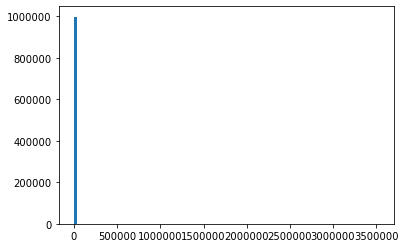

In [9]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

#Graph:

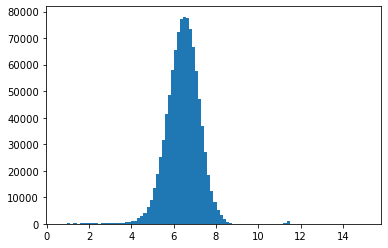

In [10]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [11]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

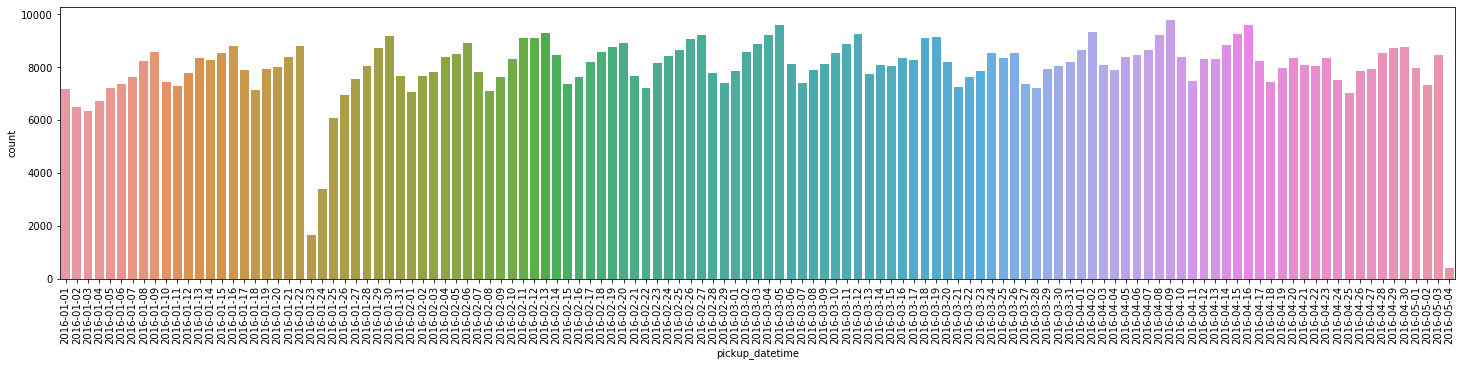

In [13]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize = (25, 5))
date_count_plot = sns.countplot(
  x = date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);
#Graph:

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

#Graph:

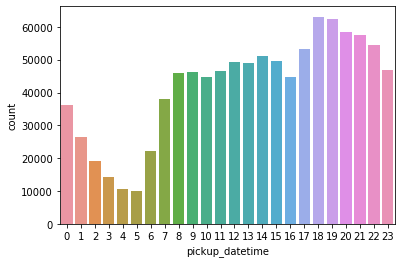

In [14]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


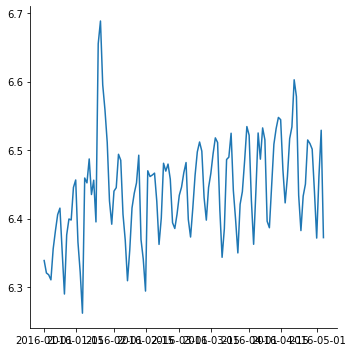

In [0]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');
#Graph:

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [15]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis = 1, keys = ['day', 'hour',]
  )
  
  return X, data_frame.log_trip_duration

In [16]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [17]:
X_train.head()
#Table:

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [19]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse = False),[1])], remainder = "passthrough")

In [20]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)
#Result:

Воспользуемся классом `Ridge` и обучим модель.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [22]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [23]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760843

Давайте попробуем сделать лучше и подберем гиперпараметры модели.

In [26]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
MemoryError: Unable to allocate 153. MiB for an array with shape (800000, 25) and data type float64

  FitFailedWarning)


d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
MemoryError: Unable to allocate 153. MiB for an array with shape (800000, 25) and data type float64

  FitFailedWarning)


d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
MemoryError: Unable to allocate 153. MiB for an array with shape (800000, 25) and data type float64

  FitFailedWarning)
d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
MemoryError: Unable to allocate 153. MiB for an array with shape (800000, 25) and data type float64

  FitFailedWarning)


In [27]:
mean_squared_error(grid_searcher.predict(X_test), y_test)
#Result:

0.6538363683902112

In [28]:
grid_searcher.best_params_
#Result:

{'alpha': 100.0}

d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\files\pycharm\machinelearningbasics\venv\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


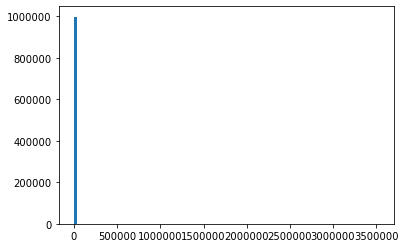

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

df = df.drop('dropoff_datetime', axis=1)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df = df.sort_values(by='pickup_datetime')

df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

df_train.trip_duration.hist(bins=100, grid=False, )

import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

#Graph:

# Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. Какой из этих графиков соответствует правильному?


In [26]:
df_train2 = df_train
df_train2.pickup_datetime = pd.to_datetime(df_train2.pickup_datetime)
weekday = df_train2.pickup_datetime.apply(lambda x: x.day_name())
sns.countplot(x=weekday.sort_index())

TypeError: '<' not supported between instances of 'str' and 'int'

# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features.

In [10]:
def create_features(data_frame):
  X = pd.concat([
      data_frame['pickup_datetime'].apply(lambda x: x.timetuple().tm_yday),
      data_frame['pickup_datetime'].apply(lambda x: x.hour),
      pd.Series(np.zeros((data_frame['pickup_datetime'].size), dtype=np.bool), index=data_frame['pickup_datetime'].index),
      data_frame['pickup_datetime'].apply(lambda x: x.weekday()) # задание 3
     ], axis=1, keys=['day', 'hour', 'anomaly', 'weekday']
  )
  return X, data_frame['log_trip_duration']


X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

X_train
#Table:

,day,hour,anomaly,weekday
96469,1,0,False,4
223872,1,0,False,4
713067,1,0,False,4
652463,1,0,False,4
722901,1,0,False,4
...,...,...,...,...
1384418,125,3,False,2
1100978,125,3,False,2
630885,125,3,False,2
567651,125,3,False,2


In [11]:
def find_anomalies(data_series):
    data_series = data_series.value_counts().sort_index()
    
    data_std = np.std(data_series)
    data_mean = np.mean(data_series)
    # Set upper and lower limit to 3 standard deviation
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    anomalies = []
    for outlier in enumerate(data_series):
        if outlier[1] > upper_limit or outlier[1] < lower_limit:
            anomalies.append(outlier[0]+1)
    return anomalies


train_anomalies = find_anomalies(X_train['day'])
test_anomalies = find_anomalies(X_test['day'])

train_anomalies
#Result:

[23, 24, 125]

In [12]:
if train_anomalies:
    for day in train_anomalies:
        X_train.loc[X_train['day'] == float(day), 'anomaly'] = True

if test_anomalies:
    for day in test_anomalies:
        X_test.loc[X_test['day'] == float(day), 'anomaly'] = True     
        
X_train
#Table:

,day,hour,anomaly,weekday
96469,1,0,False,4
223872,1,0,False,4
713067,1,0,False,4
652463,1,0,False,4
722901,1,0,False,4
...,...,...,...,...
1384418,125,3,True,2
1100978,125,3,True,2
630885,125,3,True,2
567651,125,3,True,2


# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.

2. Заново проведите one-hot кодирование. Сколько признаков у вас получилось?

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

X_train.shape
#Result:

(1000000, 27)

In [7]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[26])], remainder="passthrough")

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

X_train.shape
#Result:

(1000000, 33)

# Вопрос 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).


In [8]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [27]:
lasso = Lasso(alpha=2.65e-05)
lasso.fit(X_train, y_train)

mean_squared_error(y_test, lasso.predict(X_test))
#Result:

0.6614982790429176

In [22]:
for i in np.sort(np.abs(lasso.coef_)):
    print(i)
#Result:

0.0007504874145139141
0.004304502017149073
0.009413939843830774
0.017553971769071985
